In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from make_exp import *

In [2]:
def belief_update(strat1,strat2,b,u1,u2,beliefs):
    b11, b21, b12 = b[0,0], b[1,0], b[2,0]
    b22 = 1 - np.sum(b)
    p_t1_is_1 = b11 + b12
    p_t1_is_2 = 1 - p_t1_is_1
    p_t2_is_1 = b11 + b21
    p_t2_is_2 = 1 - p_t2_is_1
    
    one = lambda x,y: (1 if np.all(x==y) else 0)
    denom1 = one(u1,strat1[1])*p_t1_is_1 + one(u1,strat1[2])*p_t1_is_2
    denom2 = one(u2,strat2[1])*p_t2_is_1 + one(u2,strat2[2])*p_t2_is_2
    denom = denom1*denom2
    b11_next = one(u1,strat1[1])*one(u2,strat2[1])*p_t1_is_1*p_t2_is_1/denom
    b21_next = one(u1,strat1[2])*one(u2,strat2[1])*p_t1_is_2*p_t2_is_1/denom
    b12_next = one(u1,strat1[1])*one(u2,strat2[2])*p_t1_is_1*p_t2_is_2/denom
    b_next = vec(b11_next, b21_next, b12_next)
    return beliefs[np.argmin(np.sum(np.abs(beliefs-b_next),axis=1))]

def arr_tup(x):
    return tuple(x.flatten())

In [4]:
# Open data
dir = 'data/1d'
exp = "1d_single_5_11"
with open(dir+'/V_1'+'_'+exp+'.pkl', 'rb') as f:
    V1 = pickle.load(f)
with open(dir+'/V_2'+'_'+exp+'.pkl', 'rb') as f:
    V2 = pickle.load(f)
with open(dir+'/pi_1'+'_'+exp+'.pkl', 'rb') as f:
    pi1 = pickle.load(f)
with open(dir+'/pi_2'+'_'+exp+'.pkl', 'rb') as f:
    pi2 = pickle.load(f)

In [5]:
states, actions, types, dynamics, r1, r2, beliefs = make_1d_exp(5,11)

In [6]:
def project_state(s):
    return states[np.argmin([np.linalg.norm(s - s_) for s_ in states])]

def step(state,pi1,pi2,theta1,theta2,t):
    x1,x2,b = decompose_dim(state,1)
    u1 = pi1[t][arr_tup(state)][theta1]
    u2 = pi2[t][arr_tup(state)][theta2]
    x_next = dynamics(combine(x1,x2),u1,u2)
    b_next = belief_update(pi1[t][arr_tup(state)],pi2[t][arr_tup(state)],b,u1,u2,beliefs)
    r1_ = r1(state,u1,u2,theta1)
    r2_ = r2(state,u1,u2,theta2)
    s_next = combine(x_next,b_next)
    return s_next, r1_, r2_

def simulate(state,theta1,theta2,T):
    state = project_state(state)
    x = [state]
    r1s = []
    r2s = []
    for t in range(T):
        state, r1_, r2_ = step(state,pi1,pi2,theta1,theta2,t)
        x.append(state)
        r1s.append(r1_)
        r2s.append(r2_)
    return x, r1s, r2s

def eval_v(state, t, theta1, theta2):
    x1, x2 = (arr_tup(state), theta1), (arr_tup(state), theta2)
    return V1[t][x1], V2[t][x2]

In [7]:
# for k in V1[0].keys():
#     s, t = k
#     if s[0] == 1 and s[1] == 6:
#         print(t, V1[0][k])
valid = []
for s0 in states:
    v1s, v2s = [], []
    for t1 in types:
        for t2 in types:
            v1,v2 = eval_v(s0, 0, t1, t2)
            v1s.append(v1)
            v2s.append(v2)
    if np.all(np.array(v1s) > -1000) and np.all(np.array(v2s) > -1000):
        valid.append(s0)

In [8]:
print(len(valid))

73


In [9]:
# print unique states
xs = []
for v in valid:
    x1,x2,b = decompose_dim(v,1)
    x = arr_tup(combine(x1,x2))
    if x not in xs:
        xs.append(x)
print(xs)

[(0.0, 0.0), (1.0, 0.0), (1.0, 2.0), (2.0, 1.0), (2.0, 2.0), (2.0, 3.0), (3.0, 1.0), (4.0, 3.0), (4.0, 4.0)]


In [10]:
def find_bs(x1,x2):
    bs = []
    i = 0
    inds = []
    for v in valid:
        x1_,x2_,b = decompose_dim(v,1)
        if x1_ == x1 and x2_ == x2:
            bs.append(b)
            inds.append(i)
        i += 1
    return bs, inds

In [11]:
bs, inds = find_bs(3,1)

In [12]:
def plot_traj(traj):
    # b11, b21, b12 = b[0,0], b[1,0], b[2,0]
    x1s = [decompose_dim(s,1)[0][0,0] for s in traj]
    x2s = [decompose_dim(s,1)[1][0,0] for s in traj]
    b11s = [decompose_dim(s,1)[2][0,0] for s in traj]
    b21s = [decompose_dim(s,1)[2][1,0] for s in traj]
    b12s = [decompose_dim(s,1)[2][2,0] for s in traj]
    b22s = [1-np.sum(decompose_dim(s,1)[2]) for s in traj]
    plt.figure(figsize=(3,3))
    plt.title(str(arr_tup(traj[0])))
    plt.plot(x1s, label='x1')
    plt.plot(x2s, label='x2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(3,3))
    plt.title(str(arr_tup(traj[0])))
    plt.plot(b11s, label='b11')
    plt.plot(b21s, label='b21')
    plt.plot(b12s, label='b12')
    plt.plot(b22s, label='b22')
    plt.legend()
    plt.show()

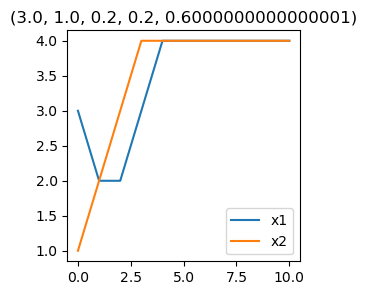

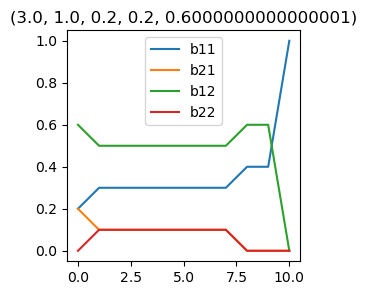

In [13]:
traj, r1s, r0s = simulate(valid[inds[0]], 1, 1, 10)
plot_traj(traj)

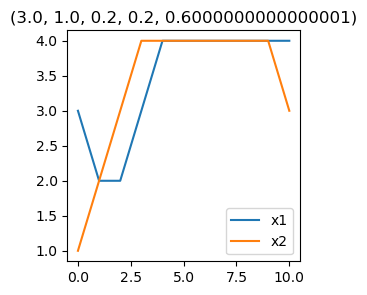

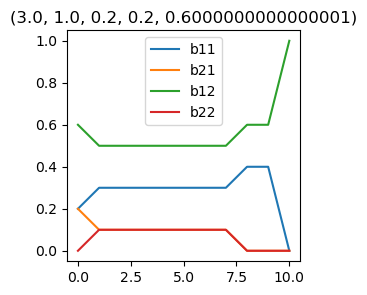

In [14]:
traj, r1s, r0s = simulate(valid[inds[0]], 1, 2, 10)
plot_traj(traj)

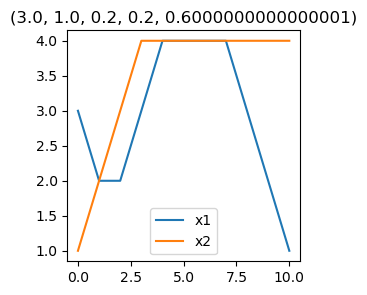

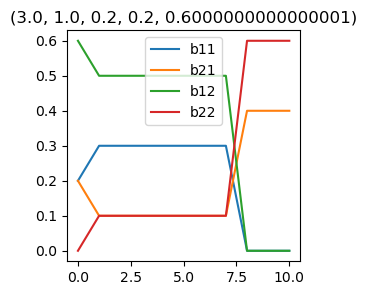

In [15]:
traj, r1s, r0s = simulate(valid[inds[0]], 2, 1, 10)
plot_traj(traj)

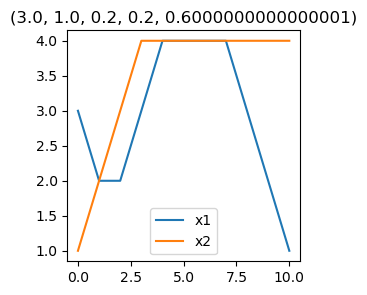

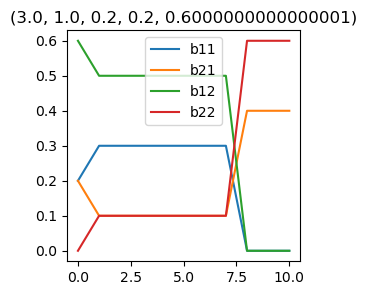

In [16]:
traj, r1s, r0s = simulate(valid[inds[0]], 2, 2, 10)
plot_traj(traj)